In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import tensorflow_datasets as tfds

# Citation
```
@inproceedings{bossard14,
  title = {Food-101 -- Mining Discriminative Components with Random Forests},
  author = {Bossard, Lukas and Guillaumin, Matthieu and Van Gool, Luc},
  booktitle = {European Conference on Computer Vision},
  year = {2014}
}
```

# Data
TensorFlow has the food 101 dataset already. We will use this! https://www.tensorflow.org/datasets/catalog/food101

Hot dog is label 55

In [2]:
ds, ds_info = tfds.load('food101', shuffle_files=True, as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete7HFEGL/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete7HFEGL/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [3]:
train_ds, valid_ds = ds["train"], ds["validation"]

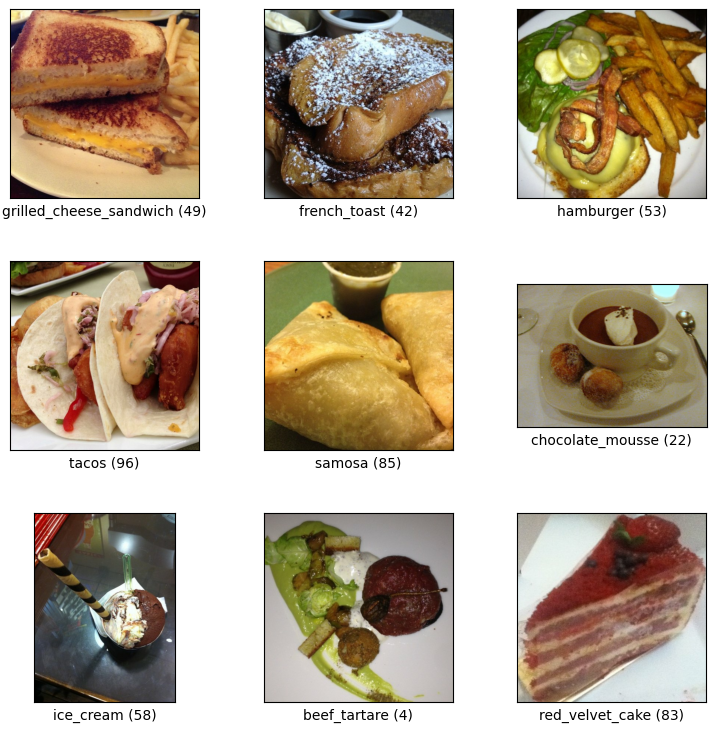

In [4]:
fig = tfds.show_examples(train_ds, ds_info)

In [5]:
MAX_SIDE_LEN = 128
HOT_DOG_CLASS = 55

train_ds = train_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32), tf.cast(label == HOT_DOG_CLASS, dtype=tf.int32))
)

valid_ds = valid_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32), tf.cast(label == HOT_DOG_CLASS, dtype=tf.int32))
)

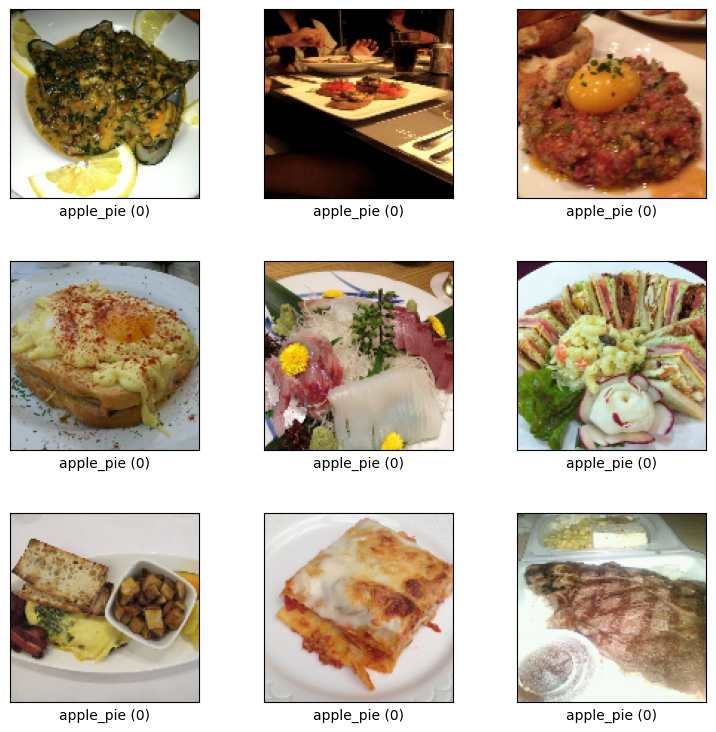

In [22]:
fig = tfds.show_examples(train_ds, ds_info)

In [23]:
train_hd_size, valid_hd_size = 750, 250
train_hotdogs = train_ds.filter(lambda _, label: label == 1).repeat(3)
train_nothotdogs = train_ds.filter(lambda _, label: label == 0)

In [24]:
valid_hotdogs = valid_ds.filter(lambda _, label: label == 1).repeat(3)
valid_nothotdogs = valid_ds.filter(lambda _, label: label == 0)

In [25]:
valid_hotdogs

<_RepeatDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [26]:
batch_size = 16
train_ds = tf.data.Dataset.sample_from_datasets([train_hotdogs, train_nothotdogs], weights=[0.5, 0.5], stop_on_empty_dataset=True)
train_ds = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

valid_ds = tf.data.Dataset.sample_from_datasets([valid_hotdogs, valid_nothotdogs], weights=[0.5, 0.5], stop_on_empty_dataset=True)
valid_ds = valid_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [30]:
for image_batch, label_batch in train_ds.take(1):
  print(image_batch)
  print(label_batch)

tf.Tensor(
[[[[ 21  25  30]
   [ 23  25  30]
   [ 23  24  28]
   ...
   [ 37  35  48]
   [ 45  40  53]
   [ 56  41  53]]

  [[ 26  27  31]
   [ 23  23  28]
   [ 26  25  31]
   ...
   [ 37  36  47]
   [ 42  40  50]
   [ 52  43  51]]

  [[ 37  30  29]
   [ 34  27  27]
   [ 35  29  32]
   ...
   [ 42  39  50]
   [ 40  36  45]
   [ 48  43  49]]

  ...

  [[145  93  90]
   [144  89  88]
   [146  87  86]
   ...
   [ 33  25  36]
   [ 44  41  49]
   [ 42  39  43]]

  [[150  97  95]
   [143  88  86]
   [147  88  88]
   ...
   [ 45  34  43]
   [ 49  42  51]
   [ 61  55  61]]

  [[152  99  97]
   [148  93  92]
   [152  93  93]
   ...
   [ 50  34  44]
   [ 43  31  41]
   [ 51  39  47]]]


 [[[  2   2   0]
   [  4   5   0]
   [  4   5   0]
   ...
   [  4   9   7]
   [  1   3   0]
   [  0   3   0]]

  [[ 12  10   3]
   [ 11   9   3]
   [  9   7   1]
   ...
   [  2   5   4]
   [  2   2   0]
   [  1   3   0]]

  [[ 25  16   1]
   [ 27  18   3]
   [ 28  17   5]
   ...
   [  2   3   3]
   [  3   2   0]


In [31]:
for image, label in train_ds.take(3):
  print(image[0][0][0])
  print(label)

tf.Tensor([21 25 30], shape=(3,), dtype=int32)
tf.Tensor([1 1 0 0 1 0 0 0 0 1 0 0 1 0 1 1], shape=(16,), dtype=int32)
tf.Tensor([188 156 105], shape=(3,), dtype=int32)
tf.Tensor([0 0 0 1 1 1 1 1 1 0 1 1 0 0 1 0], shape=(16,), dtype=int32)
tf.Tensor([152 158 132], shape=(3,), dtype=int32)
tf.Tensor([0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 1], shape=(16,), dtype=int32)


# Neural Network implementation

In [32]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [33]:
random.seed(0)
model = models.Sequential()
model.add(layers.Rescaling(1./255))
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(MAX_SIDE_LEN, MAX_SIDE_LEN, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1))

In [34]:
lr = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [35]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs,
  verbose=1
)

Epoch 1/50
287/287 [==============================] - 831s 3s/step - loss: 1.5184 - accuracy: 0.5169 - val_loss: 1.1975 - val_accuracy: 0.6239
Epoch 2/50
287/287 [==============================] - 407s 1s/step - loss: 1.0340 - accuracy: 0.5659 - val_loss: 0.9277 - val_accuracy: 0.6519
Epoch 3/50
287/287 [==============================] - 400s 1s/step - loss: 0.8607 - accuracy: 0.5881 - val_loss: 0.8192 - val_accuracy: 0.6753
Epoch 4/50
287/287 [==============================] - 382s 1s/step - loss: 0.7759 - accuracy: 0.6225 - val_loss: 0.7598 - val_accuracy: 0.6864
Epoch 5/50
287/287 [==============================] - 388s 1s/step - loss: 0.7233 - accuracy: 0.6360 - val_loss: 0.7313 - val_accuracy: 0.7072
Epoch 6/50
287/287 [==============================] - 395s 1s/step - loss: 0.6783 - accuracy: 0.6704 - val_loss: 0.6930 - val_accuracy: 0.6942
Epoch 7/50
287/287 [==============================] - 396s 1s/step - loss: 0.6333 - accuracy: 0.6977 - val_loss: 0.6918 - val_accuracy: 0.7014

In [36]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in valid_ds.take(1):
  images = image_batch
  labels = label_batch

<Figure size 1000x1000 with 0 Axes>

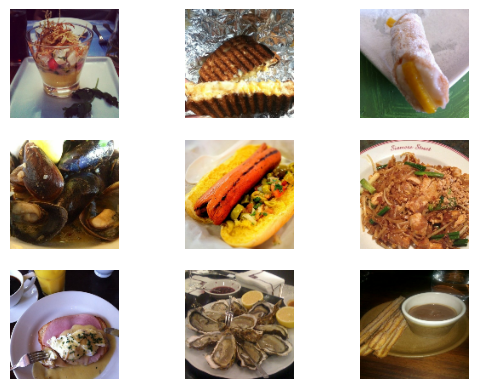

In [37]:
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(images[i])
  plt.axis("off")

In [38]:
labels[:9]

<tf.Tensor: shape=(9,), dtype=int32, numpy=array([0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int32)>